# Creating a phasescreen from atmospheric turbulence and evolving it.

## Procedure:
1. The telescope aperture and other relevant parameters are set up.
2. The multi-layer atmosphere is defined over the telescope aperture.
3. A de-magnifier is created to bring the pupil down to the size of the instrumental optics.
4. The atmosphere then evolves with time.

### Step 1: Installing hcipy on Colab.

**NOTE:** Skip this step if you have a local installation.

In [1]:
import sys
sys.path.insert(1, '../../hcipy')

### Step 2: Importing necessary libraries and setting up optical system.

In [2]:
## Necessary imports
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt

In [7]:
## Create aperture and pupil/focal grids for the optical instruments
wavelength = 532e-9
N = 512
D = 10.5e-3 # Size of the instrumental pupil plane
pupil_grid = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)
wfs_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)
aperture = circular_aperture(D)

# Telescope parameters
Dtel=4 # Size of telescope pupil plane
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)

# Atmosphere parameters
pixels_per_frame = 1 # in this way you can finely control how the phasescreen moves across the aperture
velocity = np.array([pixels_per_frame,0]) # 2D array, with the x and y componenet of wind velocity
L0 = 40 # outer scale
r0 = 0.2 # Fried parameter
height = 0 # creating just one layer at ground level for now

# Make atmosphere
np.random.seed(42)
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity * tel_pupil_grid.delta[0], height, 2)
layers.append(layer)
atmosphere = MultiLayerAtmosphere(layers, False)

## Create a demagnifier
mag = Magnifier(10.5e-3/4) # take the pupil down from 4m to 10.5mm

# Make initial phasescreen
wf_tel = Wavefront(tel_aperture(tel_pupil_grid), wavelength)
wf_tel.total_power = 100000 # photons per second
wf = mag.forward(wf_tel) # this is the reference flat wavefront for the optics

## Create propagator from pupil to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid, wavelength)

## Create detector
science_camera = NoiselessDetector()

## Get the unit lambda/D, which is useful for plotting focal plane images
l_D = wavelength / D
plot_grid = make_focal_grid(make_pupil_grid(512), 8, 20)

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  
/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  import sys
/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.


### Step 3: Evolve the atmosphere

In [8]:
## Data to keep track of
phasescreens = [] # keeping track of atmospheric phase at different timesteps
images = [] # keeping track of focal plane images at different timesteps

## Dynamic atmosphere simulation parameters
timesteps = [1, 100, 1000]

## Evolve atmosphere to these timesteps
for timestep in timesteps:
    ## Update the phasescreen
    atmosphere.evolve_until(timestep)
    wfatms_tel = atmosphere.forward(wf_tel) # phasescreen at telescope aperture
    wfatms = mag.forward(wfatms_tel) # phasescreen at instrument aperture
    sci_img = prop(wfatms).power # focal plane image
    
    phasescreens.append(wfatms.phase)
    images.append(sci_img)

Text(0.5, 1.0, 'Time = 1000')

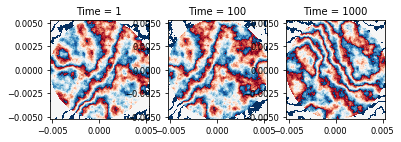

In [9]:
## Plot the phasescreens at different timesteps
plt.subplot(1, 3, 1)
imshow_field(phasescreens[0], vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title("Time = 1")
plt.subplot(1, 3, 2)
imshow_field(phasescreens[1], vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title("Time = 100")
plt.subplot(1, 3, 3)
imshow_field(phasescreens[2], vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title("Time = 1000")

Text(0.5, 1.0, 'Time = 1000')

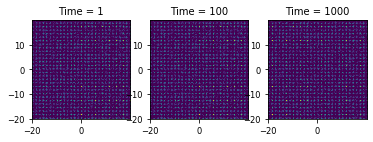

In [10]:
## Plot the focal plane images at different timesteps
plt.subplot(1, 3, 1)
imshow_field(np.log10(images[0] / images[0].max()), vmin=-6, grid=plot_grid)
plt.title("Time = 1")
plt.subplot(1, 3, 2)
imshow_field(np.log10(images[0] / images[0].max()), vmin=-6, grid=plot_grid)
plt.title("Time = 100")
plt.subplot(1, 3, 3)
imshow_field(np.log10(images[0] / images[0].max()), vmin=-6, grid=plot_grid)
plt.title("Time = 1000")

Note that the turbulence here is assumed to be frozen flow, the phasescreen moves from right to left across the aperture.